<a href="https://colab.research.google.com/github/nyck33/tennisball-tracker/blob/master/tennisball_tracker_c_perimeter550data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using balloon and shapes

upload sample2.zip and mrcnn.zip and unzip here

In [1]:
#Get all files from git or Drive
#!git clone https://github.com/nyck33/tennisball-tracker.git

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Remount drive if necessary

#drive.mount("/content/drive", force_remount=True)
#from google.colab import drive
#drive.mount('/content/gdrive')

#!unzip mrcnn.zip

In [0]:
#Weights are in Drive
#!wget "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"

In [4]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")
ROOT_DIR = os.path.abspath("drive/My Drive/matterport-balltracker/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from balloon import BalloonConfig, BalloonDataset

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [0]:
config = BalloonConfig()
#BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")
BALLOON_DIR = os.path.join(ROOT_DIR, "sample2") #/sample2/

In [0]:
#!unzip sample2.zip

In [7]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset_train = BalloonDataset()
dataset_train.load_balloon(BALLOON_DIR, "train")

# Must call before using the dataset
dataset_train.prepare()

#############val set
dataset_val = BalloonDataset()
dataset_val.load_balloon(BALLOON_DIR, "val")

dataset_val.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    


Image Count: 329
Class Count: 2
  0. BG                                                
  1. tennisball                                        


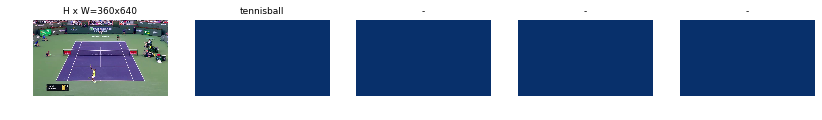

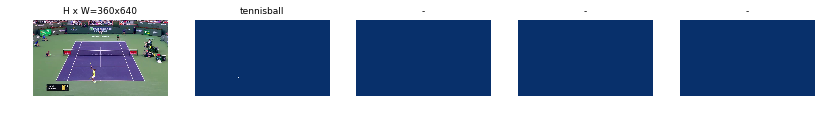

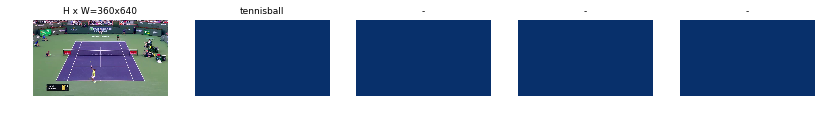

In [8]:
# Load and display random samples
#image_ids = np.random.choice(dataset.image_ids, 4)
image_ids = dataset_train.image_ids[5:8]
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
    #WEIGHTS_DIR = "resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5"
    #IMAGENET_DIR = os.path.join(ROOT_DIR, WEIGHTS_DIR)
    #model.load_weights(IMAGENET_DIR)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

94658560/94653016 [==============================] - 4s 0us/step


Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [0]:
#####################
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
'''
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')
'''
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/matterport-balltracker/logs/tennisball20190604T1204/mask_rcnn_tennisball_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 350s 3s/step - loss: 2.5724 - rpn_class_loss: 0.5051 - rpn_bbox_loss: 1.9416 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0135 - val_loss: 2.2036 - val_rpn_class_loss: 0.2058 - val_rpn_bbox_loss: 1.9502 - val_mrcnn_class_loss: 4.7420e-04 - val_mrcnn_bbox_loss: 0.0202 - val_mrcnn_mask_loss: 0.0269


In [13]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /content/drive/My Drive/matterport-balltracker/logs/tennisball20190604T1204/mask_rcnn_tennisball_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_br

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
100/100 [==============================] - 516s 5s/step - loss: 1.5715 - rpn_class_loss: 0.1816 - rpn_bbox_loss: 1.1228 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1186 - val_loss: 1.7199 - val_rpn_class_loss: 0.1663 - val_rpn_bbox_loss: 1.4826 - val_mrcnn_class_loss: 5.6985e-04 - val_mrcnn_bbox_loss: 0.0439 - val_mrcnn_mask_loss: 0.0266


In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_tennisball.h5")
model.keras_model.save_weights(model_path)

In [0]:
#load weights
model.load_weights("drive/My Drive/matterport-balltracker/logs/mask_rcnn_tennisball.h5")

In [16]:
class InferenceConfig(BalloonConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /content/drive/My Drive/matterport-balltracker/logs/tennisball20190604T1204/mask_rcnn_tennisball_0002.h5
Re-starting from epoch 2


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  198.00000  max:  800.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


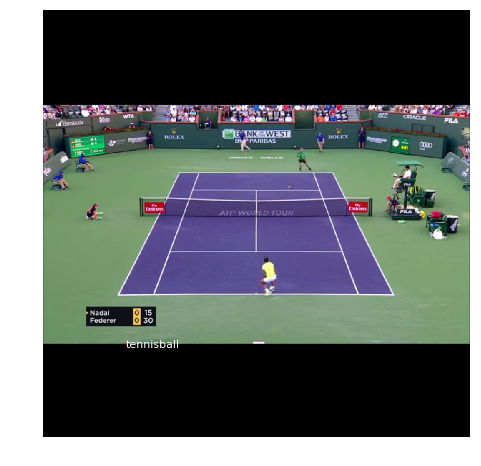

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  174.00000  max:  800.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


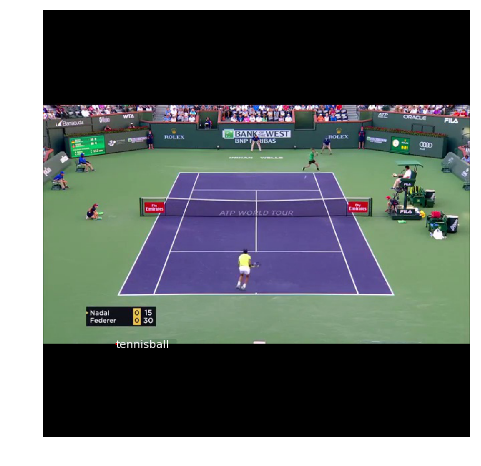

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  179.00000  max:  800.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


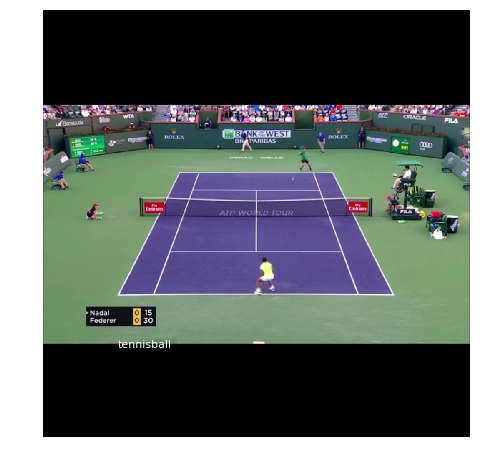

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  149.00000  max:  800.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


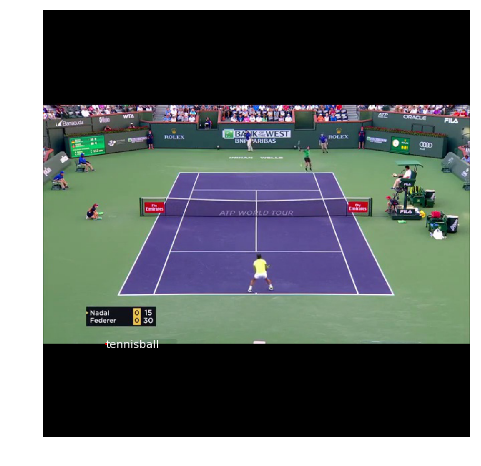

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  198.00000  max:  800.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


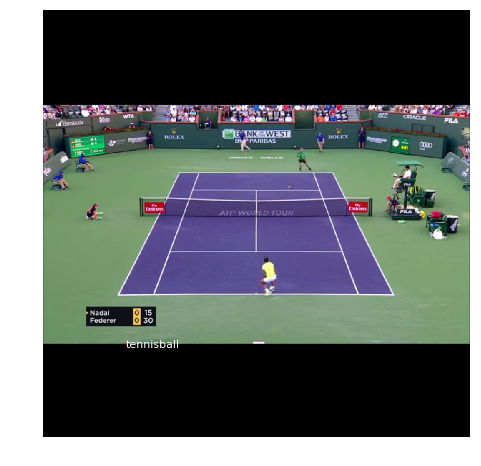

In [17]:
# Test on a random image
for i in range(5):
    image_id = random.choice(dataset_val.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))